In [1]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers as tf_layers

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import time
import pathlib

# Dataset

In [2]:
BATCH_SIZE = 32

In [3]:
root_dir = pathlib.Path().cwd()/"downloaded_images"

train_ds = tf.keras.utils.image_dataset_from_directory(root_dir,
                                                       label_mode='categorical',
                                                       image_size=(32, 32),
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=True,
                                                       seed=111,
                                                       validation_split=0.2,
                                                       subset='training')

test_ds = tf.keras.utils.image_dataset_from_directory(root_dir,
                                                      label_mode='categorical',
                                                      image_size=(32, 32),
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True,
                                                      seed=111,
                                                      validation_split=0.2,
                                                      subset='validation')

label_to_class = {i: name for i, name in enumerate(train_ds.class_names)}

Found 980 files belonging to 3 classes.
Using 784 files for training.
Found 980 files belonging to 3 classes.
Using 196 files for validation.


In [4]:
# for later
train_ds_256 = tf.keras.utils.image_dataset_from_directory(root_dir,
                                                          label_mode='categorical',
                                                          image_size=(256, 256),
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          seed=111,
                                                          validation_split=0.2,
                                                          subset='training')

test_ds_256 = tf.keras.utils.image_dataset_from_directory(root_dir,
                                                         label_mode='categorical',
                                                         image_size=(256, 256),
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         seed=111,
                                                         validation_split=0.2,
                                                         subset='validation')

Found 980 files belonging to 3 classes.
Using 784 files for training.
Found 980 files belonging to 3 classes.
Using 196 files for validation.


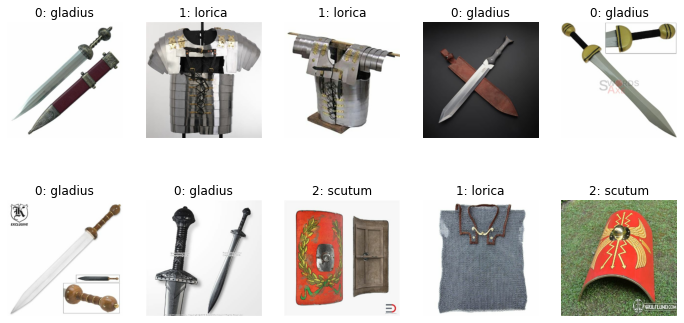

In [5]:
plt.rcParams['figure.figsize'] = [12, 6]

for i, (x, y) in enumerate(train_ds_256.unbatch().take(10)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(tf_layers.Rescaling(1./255.)(x))
    y = tf.argmax(y).numpy()
    plt.title(f'{y}: {label_to_class[y]}')
    plt.axis('off')
    
plt.savefig('./plots/sample_images.jpg')
plt.show()

# Predictions

## Utils

In [6]:
EPOCHS = 150

def compile_and_fit(model, train_ds, test_ds, epochs=EPOCHS, learning_rate=0.0005, momentum=0.9):
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum), 
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])

    start = time.time()
    model_history = model.fit(train_ds,
                              epochs=epochs, 
                              validation_data=(test_ds))
    end = time.time()
    return model_history, end - start

In [7]:
def _moving_average(arr, n):
    cumsum = np.cumsum(np.concatenate(([0] * n, arr)))
    return (cumsum[n:] - cumsum[:-n]) / np.concatenate((np.arange(1, n + 1), np.full((len(arr) - n,), n)))

def _plot_score_vs_epochs(sub_idx, x, y, xlabel, ylabel, title=None, y_min=None, y_max=None, ma=10):
    y = _moving_average(y, ma)
    plt.subplot(2, 2, sub_idx)
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if title is not None:
        plt.title(title)
    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)
    
def plot_all_score_vs_epochs(model_history, model_name, epochs=EPOCHS, loss_min=0.00, loss_max=2.4, ma=10):
    plt.rcParams['figure.figsize'] = [12, 10]
    
    if epochs is None:
        epochs = EPOCHS
    x = np.arange(1, epochs + 1)  
    
    _plot_score_vs_epochs(1, x, model_history.history['loss'], 'epoch', 'loss',
                          title='Train Set Loss',     y_min=loss_min, y_max=loss_max, ma=ma)
    _plot_score_vs_epochs(2, x, model_history.history['categorical_accuracy'], 'epoch', 'accuracy',
                          title='Train Set Accuracy', y_min=0.05, y_max=1.05, ma=ma)
    _plot_score_vs_epochs(3, x, model_history.history['val_loss'], 'epoch', 'loss',
                          title='Test Set Loss',      y_min=loss_min, y_max=loss_max, ma=ma)
    _plot_score_vs_epochs(4, x, model_history.history['val_categorical_accuracy'], 'epoch', 'accuracy',
                          title='Test Set Accuracy',  y_min=0.05, y_max=1.05, ma=ma)
    plt.tight_layout()
    plt.savefig(f'plots/{model_name}_plots.jpg')
    plt.show()

In [8]:
def print_weights_stats(model):
    trainable = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    non_trainable = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    print(f'trainable: {trainable}, non-trainable: {non_trainable}')

## Model 1 (the best from lab3)

In [9]:
def convolution_block_with_opt_gap(n_filters, dropout_rate, gap=False, activation='relu'):
    if gap:
        pool_or_gap_layer = tf_layers.GlobalAveragePooling2D()
    else:
        pool_or_gap_layer = tf_layers.MaxPooling2D(pool_size=(2, 2))

    return [tf_layers.Conv2D(n_filters, (3, 3), padding='same', activation=activation),
            tf_layers.BatchNormalization(),
            tf_layers.Conv2D(n_filters, (3, 3), padding='same', activation=activation),
            tf_layers.BatchNormalization(),
            pool_or_gap_layer,
            tf_layers.Dropout(dropout_rate)]

model_1 = tf.keras.Sequential(layers=[
    tf.keras.Input(shape=(32, 32, 3)),
    tf_layers.Rescaling(1./255.),
    *convolution_block_with_opt_gap( 20, 0.1),
    *convolution_block_with_opt_gap( 40, 0.2),
    *convolution_block_with_opt_gap( 80, 0.3),
    *convolution_block_with_opt_gap(160, 0.4, gap=True),
    tf_layers.Flatten(),
    tf_layers.Dense(3, activation='softmax')
], name='model_1')

model_1_history, _ = compile_and_fit(model_1, train_ds, test_ds)

Epoch 1/150
25/25 [==============================] - 3s 31ms/step - loss: 1.0619 - categorical_accuracy: 0.4311 - val_loss: 1.1056 - val_categorical_accuracy: 0.2959
Epoch 2/150
25/25 [==============================] - 0s 15ms/step - loss: 0.8277 - categorical_accuracy: 0.6467 - val_loss: 1.1119 - val_categorical_accuracy: 0.2959
Epoch 3/150
25/25 [==============================] - 0s 15ms/step - loss: 0.6949 - categorical_accuracy: 0.7283 - val_loss: 1.1278 - val_categorical_accuracy: 0.2959
Epoch 4/150
25/25 [==============================] - 0s 15ms/step - loss: 0.6025 - categorical_accuracy: 0.7666 - val_loss: 1.1090 - val_categorical_accuracy: 0.3367
Epoch 5/150
25/25 [==============================] - 0s 15ms/step - loss: 0.5727 - categorical_accuracy: 0.7806 - val_loss: 1.1097 - val_categorical_accuracy: 0.3367
Epoch 6/150
25/25 [==============================] - 0s 15ms/step - loss: 0.5537 - categorical_accuracy: 0.7883 - val_loss: 1.1137 - val_categorical_accuracy: 0.3367
Epoc

25/25 [==============================] - 0s 15ms/step - loss: 0.1161 - categorical_accuracy: 0.9566 - val_loss: 1.0800 - val_categorical_accuracy: 0.7755
Epoch 51/150
25/25 [==============================] - 0s 15ms/step - loss: 0.1116 - categorical_accuracy: 0.9605 - val_loss: 0.2552 - val_categorical_accuracy: 0.9184
Epoch 52/150
25/25 [==============================] - 0s 15ms/step - loss: 0.1134 - categorical_accuracy: 0.9617 - val_loss: 0.2173 - val_categorical_accuracy: 0.9337
Epoch 53/150
25/25 [==============================] - 0s 16ms/step - loss: 0.0929 - categorical_accuracy: 0.9707 - val_loss: 0.2044 - val_categorical_accuracy: 0.9184
Epoch 54/150
25/25 [==============================] - 0s 15ms/step - loss: 0.0799 - categorical_accuracy: 0.9770 - val_loss: 0.2996 - val_categorical_accuracy: 0.9184
Epoch 55/150
25/25 [==============================] - 0s 15ms/step - loss: 0.0988 - categorical_accuracy: 0.9605 - val_loss: 0.6105 - val_categorical_accuracy: 0.8418
Epoch 56/15

25/25 [==============================] - 0s 15ms/step - loss: 0.0236 - categorical_accuracy: 0.9936 - val_loss: 0.2889 - val_categorical_accuracy: 0.9184
Epoch 100/150
25/25 [==============================] - 0s 17ms/step - loss: 0.0367 - categorical_accuracy: 0.9898 - val_loss: 0.2789 - val_categorical_accuracy: 0.9490
Epoch 101/150
25/25 [==============================] - 0s 16ms/step - loss: 0.0448 - categorical_accuracy: 0.9872 - val_loss: 0.3554 - val_categorical_accuracy: 0.9133
Epoch 102/150
25/25 [==============================] - 0s 15ms/step - loss: 0.0383 - categorical_accuracy: 0.9885 - val_loss: 0.3238 - val_categorical_accuracy: 0.9184
Epoch 103/150
25/25 [==============================] - 1s 17ms/step - loss: 0.0355 - categorical_accuracy: 0.9885 - val_loss: 0.2874 - val_categorical_accuracy: 0.9184
Epoch 104/150
25/25 [==============================] - 1s 17ms/step - loss: 0.0241 - categorical_accuracy: 0.9936 - val_loss: 0.3024 - val_categorical_accuracy: 0.9184
Epoch 

Epoch 148/150
25/25 [==============================] - 0s 16ms/step - loss: 0.0133 - categorical_accuracy: 1.0000 - val_loss: 0.4326 - val_categorical_accuracy: 0.9235
Epoch 149/150
25/25 [==============================] - 0s 15ms/step - loss: 0.0210 - categorical_accuracy: 0.9923 - val_loss: 0.4443 - val_categorical_accuracy: 0.9184
Epoch 150/150
25/25 [==============================] - 0s 15ms/step - loss: 0.0161 - categorical_accuracy: 0.9987 - val_loss: 0.2201 - val_categorical_accuracy: 0.9235


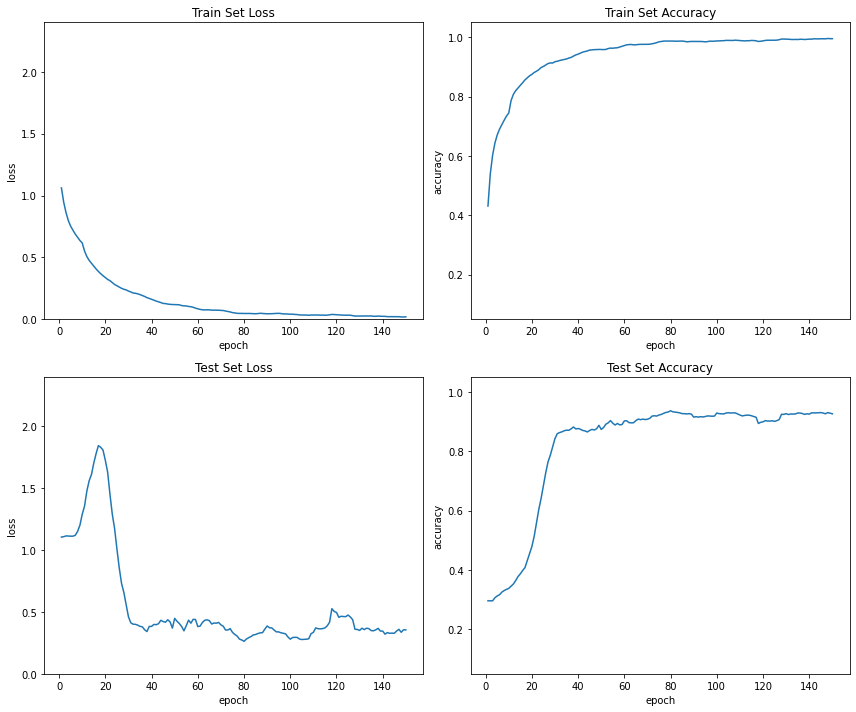

In [10]:
plot_all_score_vs_epochs(model_1_history, 'model_1')

## Model 2 (the best from lab3, loaded with weights)

In [11]:
model_2_base = tf.keras.Sequential(layers=[
    tf.keras.Input(shape=(32, 32, 3)),
    tf_layers.Rescaling(1./255.),
    *convolution_block_with_opt_gap( 20, 0.1),
    *convolution_block_with_opt_gap( 40, 0.2),
    *convolution_block_with_opt_gap( 80, 0.3),
    *convolution_block_with_opt_gap(160, 0.4, gap=True),
    tf_layers.Flatten(),
    tf_layers.Dense(10, activation='softmax')
], name='model_2_base')

model_2_base.load_weights('../lab3/saved_weights/model_6_weights')
model_2_base.trainable = False # Freeze weights and set the BatchNormalization layers to the inference mode

print_weights_stats(model_2_base)

trainable: 0.0, non-trainable: 462350


In [12]:
model_2 = tf.keras.Sequential(layers=[
    *model_2_base.layers[:-1],
    tf_layers.Dense(3, activation='softmax')
], name='model_2')

model_2_history, _ = compile_and_fit(model_2, train_ds, test_ds)

Epoch 1/150
25/25 [==============================] - 1s 20ms/step - loss: 1.2675 - categorical_accuracy: 0.3240 - val_loss: 1.1584 - val_categorical_accuracy: 0.3520
Epoch 2/150
25/25 [==============================] - 0s 11ms/step - loss: 1.1688 - categorical_accuracy: 0.4031 - val_loss: 1.0142 - val_categorical_accuracy: 0.4949
Epoch 3/150
25/25 [==============================] - 0s 11ms/step - loss: 1.0743 - categorical_accuracy: 0.4847 - val_loss: 0.9127 - val_categorical_accuracy: 0.5612
Epoch 4/150
25/25 [==============================] - 0s 11ms/step - loss: 0.9728 - categorical_accuracy: 0.5281 - val_loss: 0.8423 - val_categorical_accuracy: 0.6276
Epoch 5/150
25/25 [==============================] - 0s 11ms/step - loss: 0.9256 - categorical_accuracy: 0.5816 - val_loss: 0.7905 - val_categorical_accuracy: 0.6633
Epoch 6/150
25/25 [==============================] - 0s 11ms/step - loss: 0.8771 - categorical_accuracy: 0.6020 - val_loss: 0.7536 - val_categorical_accuracy: 0.7041
Epoc

25/25 [==============================] - 0s 13ms/step - loss: 0.6168 - categorical_accuracy: 0.7321 - val_loss: 0.5184 - val_categorical_accuracy: 0.7857
Epoch 51/150
25/25 [==============================] - 0s 11ms/step - loss: 0.6173 - categorical_accuracy: 0.7577 - val_loss: 0.5173 - val_categorical_accuracy: 0.7908
Epoch 52/150
25/25 [==============================] - 0s 12ms/step - loss: 0.6199 - categorical_accuracy: 0.7347 - val_loss: 0.5162 - val_categorical_accuracy: 0.7908
Epoch 53/150
25/25 [==============================] - 0s 13ms/step - loss: 0.6084 - categorical_accuracy: 0.7589 - val_loss: 0.5155 - val_categorical_accuracy: 0.7959
Epoch 54/150
25/25 [==============================] - 0s 14ms/step - loss: 0.6298 - categorical_accuracy: 0.7258 - val_loss: 0.5145 - val_categorical_accuracy: 0.7959
Epoch 55/150
25/25 [==============================] - 0s 14ms/step - loss: 0.6312 - categorical_accuracy: 0.7436 - val_loss: 0.5130 - val_categorical_accuracy: 0.7959
Epoch 56/15

25/25 [==============================] - 0s 12ms/step - loss: 0.6029 - categorical_accuracy: 0.7538 - val_loss: 0.4803 - val_categorical_accuracy: 0.8214
Epoch 100/150
25/25 [==============================] - 0s 12ms/step - loss: 0.5931 - categorical_accuracy: 0.7462 - val_loss: 0.4795 - val_categorical_accuracy: 0.8163
Epoch 101/150
25/25 [==============================] - 0s 12ms/step - loss: 0.5716 - categorical_accuracy: 0.7640 - val_loss: 0.4788 - val_categorical_accuracy: 0.8214
Epoch 102/150
25/25 [==============================] - 0s 12ms/step - loss: 0.5992 - categorical_accuracy: 0.7513 - val_loss: 0.4779 - val_categorical_accuracy: 0.8214
Epoch 103/150
25/25 [==============================] - 0s 12ms/step - loss: 0.5725 - categorical_accuracy: 0.7589 - val_loss: 0.4768 - val_categorical_accuracy: 0.8214
Epoch 104/150
25/25 [==============================] - 0s 12ms/step - loss: 0.5700 - categorical_accuracy: 0.7691 - val_loss: 0.4759 - val_categorical_accuracy: 0.8214
Epoch 

Epoch 148/150
25/25 [==============================] - 0s 11ms/step - loss: 0.5638 - categorical_accuracy: 0.7666 - val_loss: 0.4571 - val_categorical_accuracy: 0.8265
Epoch 149/150
25/25 [==============================] - 0s 11ms/step - loss: 0.5751 - categorical_accuracy: 0.7615 - val_loss: 0.4571 - val_categorical_accuracy: 0.8265
Epoch 150/150
25/25 [==============================] - 0s 12ms/step - loss: 0.5734 - categorical_accuracy: 0.7602 - val_loss: 0.4567 - val_categorical_accuracy: 0.8265


trainable: 483, non-trainable: 460740


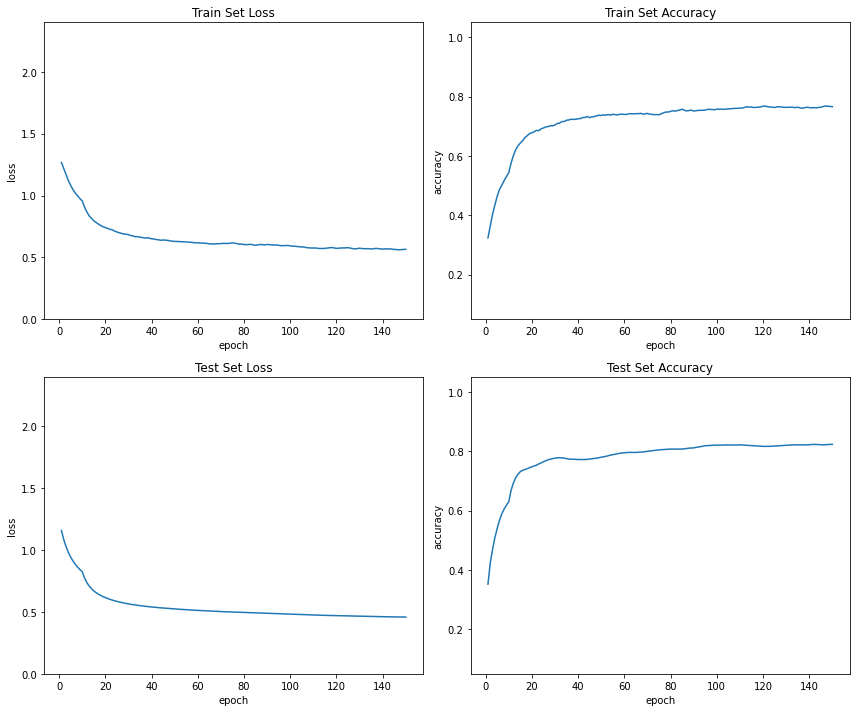

In [13]:
print_weights_stats(model_2)
plot_all_score_vs_epochs(model_2_history, 'model_2')

## Model 3 (Xception)

In [14]:
model_3_base = tf.keras.applications.Xception(include_top=False, # to get rid of two last layers (GAP + Dense)
                                              input_shape=(256, 256, 3))
model_3_base.trainable = False
print_weights_stats(model_3_base)

trainable: 0.0, non-trainable: 20861480


In [15]:
output = tf_layers.GlobalAveragePooling2D()(model_3_base.output)
output = tf_layers.Dense(3, activation='softmax')(output)

model_3 = tf.keras.Model(inputs=model_3_base.input, outputs=output)

model_3_history, _ = compile_and_fit(model_3, train_ds_256, test_ds_256, epochs=25)
model_3.save_weights('./saved_weights/model_3/model_3_weights')

Epoch 1/25
25/25 [==============================] - 8s 236ms/step - loss: 64.8694 - categorical_accuracy: 0.4490 - val_loss: 53.5169 - val_categorical_accuracy: 0.5816
Epoch 2/25
25/25 [==============================] - 5s 187ms/step - loss: 43.8790 - categorical_accuracy: 0.5651 - val_loss: 41.6460 - val_categorical_accuracy: 0.5357
Epoch 3/25
25/25 [==============================] - 5s 195ms/step - loss: 35.4112 - categorical_accuracy: 0.6480 - val_loss: 16.5575 - val_categorical_accuracy: 0.7551
Epoch 4/25
25/25 [==============================] - 5s 193ms/step - loss: 15.0776 - categorical_accuracy: 0.7347 - val_loss: 11.0158 - val_categorical_accuracy: 0.7398
Epoch 5/25
25/25 [==============================] - 5s 188ms/step - loss: 12.6116 - categorical_accuracy: 0.7717 - val_loss: 51.9998 - val_categorical_accuracy: 0.6071
Epoch 6/25
25/25 [==============================] - 5s 188ms/step - loss: 24.5690 - categorical_accuracy: 0.6620 - val_loss: 31.6792 - val_categorical_accuracy:

trainable: 6147, non-trainable: 20861480


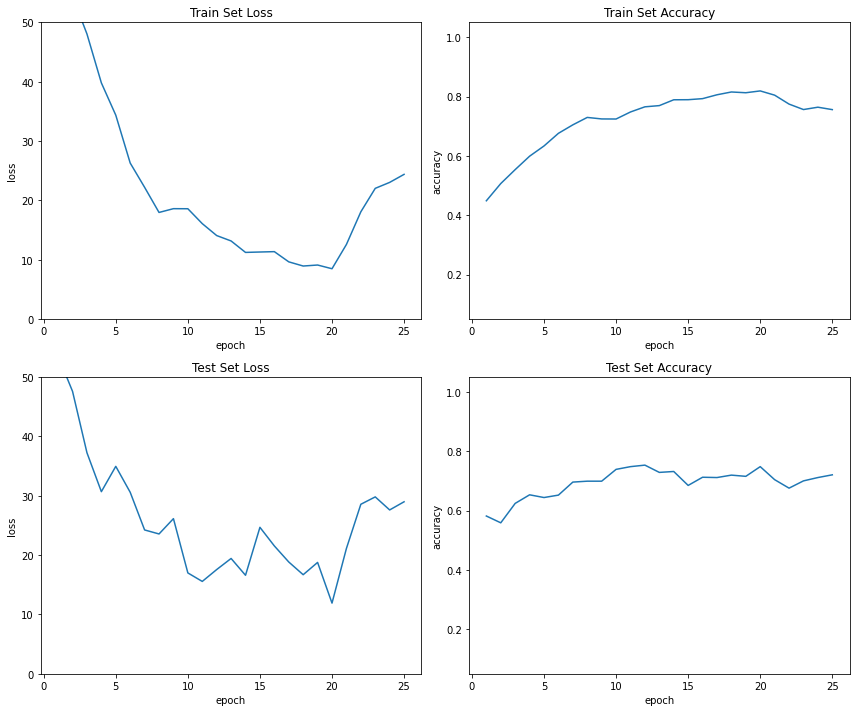

In [16]:
print_weights_stats(model_3)
plot_all_score_vs_epochs(model_3_history, 'model_3', loss_max=50., epochs=25, ma=5)

## Model 4 (Xception + fine tuning)

In [17]:
model_4 = tf.keras.models.clone_model(model_3)
model_4.load_weights('./saved_weights/model_3/model_3_weights')
model_4.trainable = True

for layer in model_4.layers:
    if layer.name.startswith('batch_normalization'):
        layer.trainable = False
        
model_4_history, _ = compile_and_fit(model_4, train_ds_256, test_ds_256, epochs=15,
                                     learning_rate=0.00005)
model_4.save_weights('./saved_weights/model_4/model_4_weights')

Epoch 1/15
25/25 [==============================] - 24s 792ms/step - loss: 1.2176 - categorical_accuracy: 0.4681 - val_loss: 1.1838 - val_categorical_accuracy: 0.6684
Epoch 2/15
25/25 [==============================] - 18s 709ms/step - loss: 0.3727 - categorical_accuracy: 0.8878 - val_loss: 0.2066 - val_categorical_accuracy: 0.9082
Epoch 3/15
25/25 [==============================] - 18s 732ms/step - loss: 0.1745 - categorical_accuracy: 0.9745 - val_loss: 0.1224 - val_categorical_accuracy: 0.9541
Epoch 4/15
25/25 [==============================] - 18s 727ms/step - loss: 0.1162 - categorical_accuracy: 0.9821 - val_loss: 0.1024 - val_categorical_accuracy: 0.9592
Epoch 5/15
25/25 [==============================] - 18s 734ms/step - loss: 0.1051 - categorical_accuracy: 0.9860 - val_loss: 0.0930 - val_categorical_accuracy: 0.9745
Epoch 6/15
25/25 [==============================] - 18s 732ms/step - loss: 0.0763 - categorical_accuracy: 0.9847 - val_loss: 0.0865 - val_categorical_accuracy: 0.974

trainable: 20808827, non-trainable: 58800


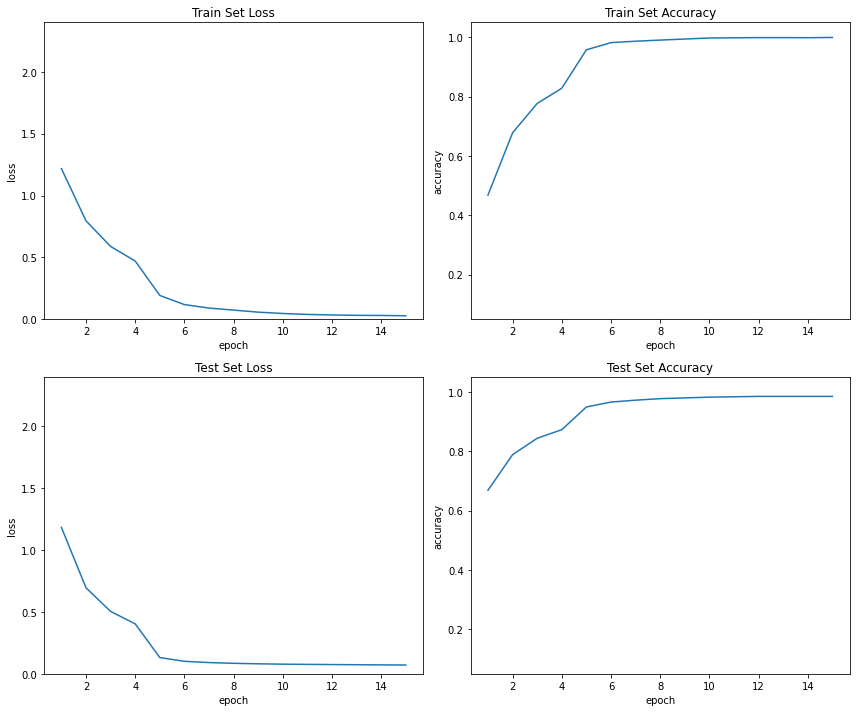

In [18]:
print_weights_stats(model_4)
plot_all_score_vs_epochs(model_4_history, 'model_4', epochs=15, ma=4)

# Investigation

In [19]:
FINAL_MODEL = model_4
SET = test_ds_256

In [20]:
images, labels = zip(*SET.unbatch())
images = np.array(images)
labels = np.array(labels)

y_pred = np.argmax(FINAL_MODEL.predict(images), axis=1)
y_pred_is_true = y_pred == np.argmax(labels, axis=1)

In [21]:
base_xception = tf.keras.Model(inputs=FINAL_MODEL.inputs, outputs=FINAL_MODEL.layers[-3].output)

In [22]:
def upscale(image, scale=32):
    return image.repeat(scale, axis=0).repeat(scale, axis=1)

## True predictions

In [23]:
x_true, y_true = images[y_pred_is_true][:12], labels[y_pred_is_true][:12]

### Single image

In [24]:
base_pred = base_xception.predict(x_true[:1])[0]
base_pred.shape

(8, 8, 2048)

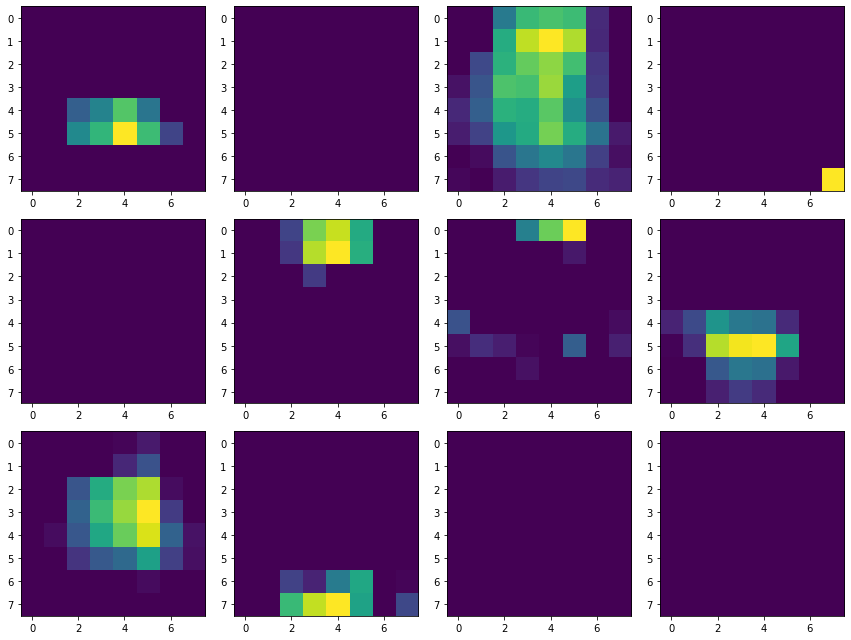

In [25]:
plt.rcParams['figure.figsize'] = [12, 9]

for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(base_pred[:, :, i])
    
plt.tight_layout()
plt.savefig('./plots/true_base_xception_channels.jpg')
plt.show()

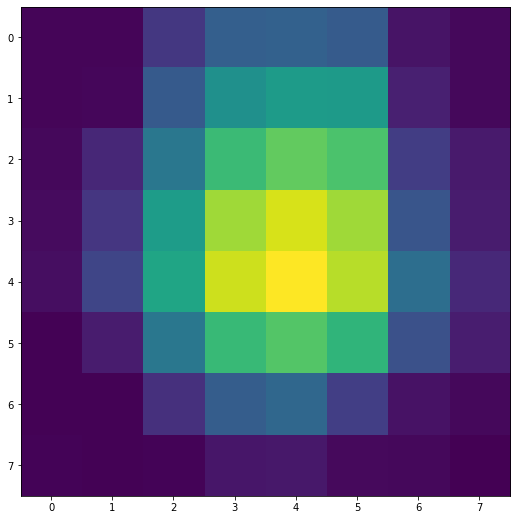

In [26]:
heatmap = np.sum(base_pred * FINAL_MODEL.layers[-1].weights[0][:, np.argmax(y_true[0])], axis=2)
plt.imshow(heatmap)
plt.savefig('./plots/true_single_heatmap')
plt.show()

### Selected images

In [27]:
base_pred_sel = base_xception.predict(x_true)
base_pred_sel.shape

(12, 8, 8, 2048)

In [28]:
heatmaps = []
for i in range(12):
    heatmap = np.sum(base_pred_sel[i] * FINAL_MODEL.layers[-1].weights[0][:, np.argmax(y_true[i])], axis=2)
    heatmap = (heatmap - np.min(heatmap)) / np.ptp(heatmap)
    heatmaps += [upscale(heatmap)]

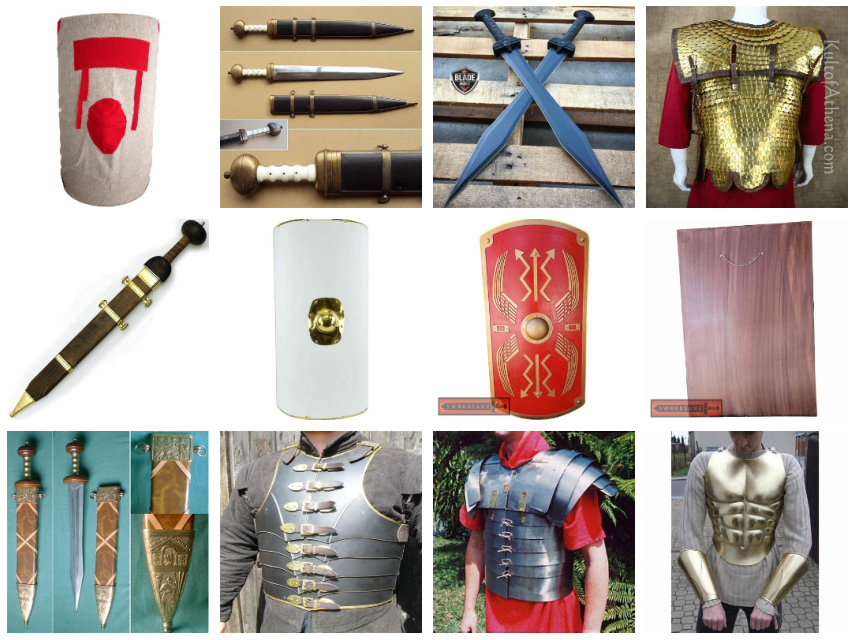

In [29]:
for i in range(12):
    plt.subplot(3, 4, i + 1)
    image = (x_true[i] - np.min(x_true[i])) / np.ptp(x_true[i])
    plt.axis('off')
    plt.imshow(image)
    
plt.tight_layout()
plt.savefig('./plots/true_images.jpg')
plt.show()

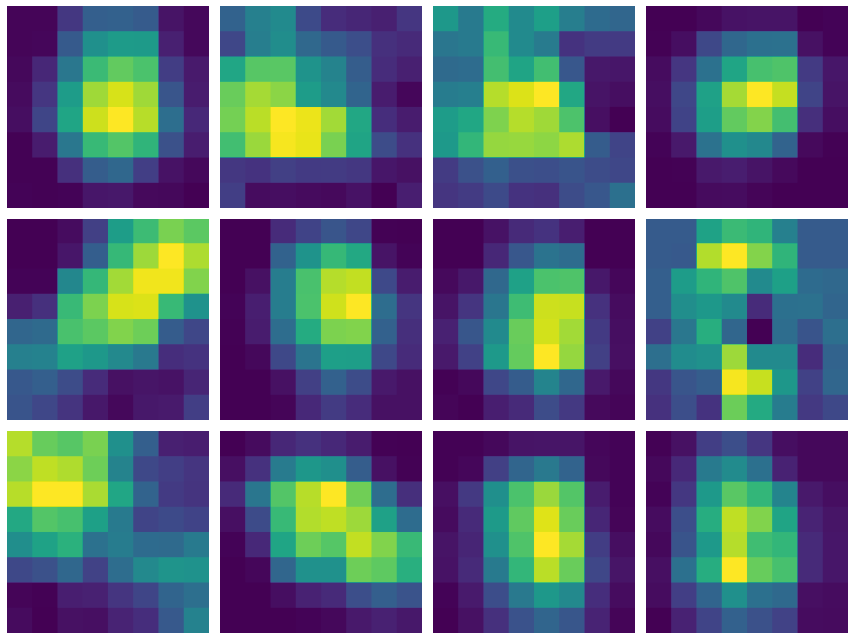

In [30]:
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(heatmaps[i])
    
plt.tight_layout()
plt.savefig('./plots/true_heatmaps.jpg')
plt.show()

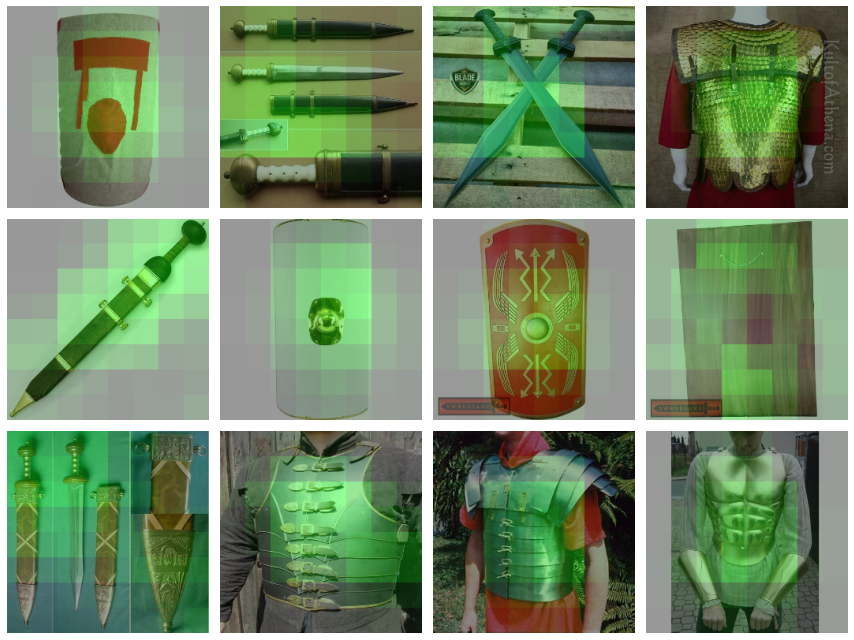

In [31]:
for i in range(12):
    plt.subplot(3, 4, i + 1)
    image = (x_true[i] - np.min(x_true[i])) / np.ptp(x_true[i])
    image[:, :, 1] *= 0.6
    image[:, :, 1] += 0.4 * heatmaps[i]
    image[:, :, 0] *= 0.6
    image[:, :, 2] *= 0.6
    plt.axis('off')
    plt.imshow(image)
    
plt.tight_layout()
plt.savefig('./plots/true_images_with_heatmaps.jpg')
plt.show()

## False predictions

In [32]:
x_false, y_false = images[np.logical_not(y_pred_is_true)][:3], labels[np.logical_not(y_pred_is_true)][:3]
y_false_pred = y_pred[np.logical_not(y_pred_is_true)][:3]

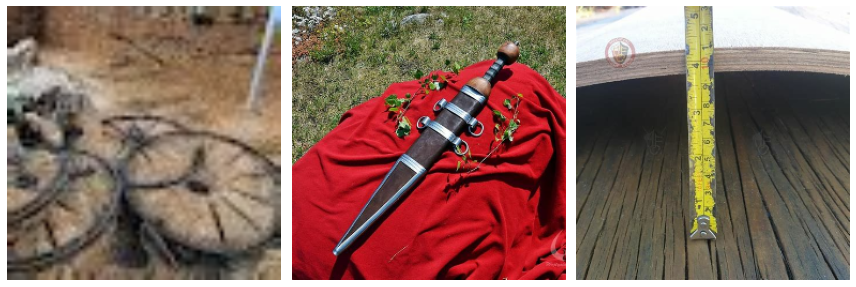

In [33]:
for i in range(3):
    plt.subplot(1, 3, i + 1)
    image = (x_false[i] - np.min(x_false[i])) / np.ptp(x_false[i])
    plt.axis('off')
    plt.imshow(image)
    
plt.tight_layout()
plt.savefig('./plots/false_images.jpg')
plt.show()

In [34]:
base_pred_false = base_xception.predict(x_false)

heatmaps_false = []
for i in range(3):
    heatmap = np.sum(base_pred_false[i] * FINAL_MODEL.layers[-1].weights[0][:, y_false_pred[i]], axis=2)
    heatmap = (heatmap - np.min(heatmap)) / np.ptp(heatmap)
    heatmaps_false += [upscale(heatmap)]

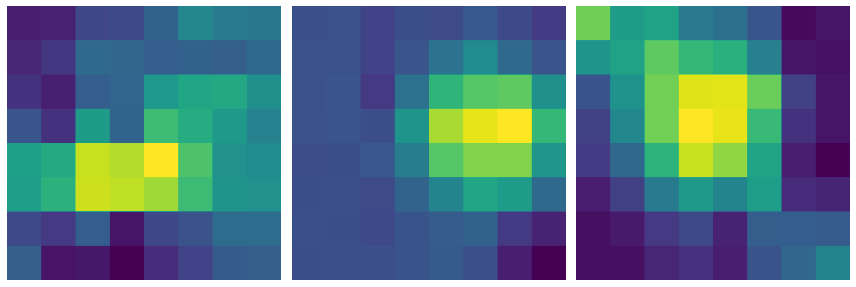

In [35]:
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.axis('off')
    plt.imshow(heatmaps_false[i])
    
plt.tight_layout()
plt.savefig('./plots/false_heatmaps.jpg')
plt.show()

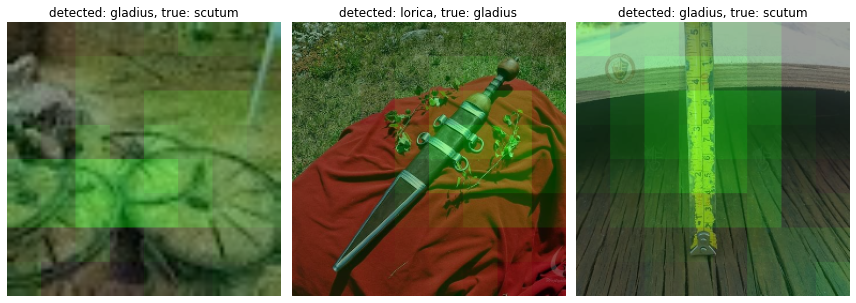

In [36]:
H_THR = 0.0

for i in range(3):
    plt.subplot(1, 3, i + 1)
    image = (x_false[i] - np.min(x_false[i])) / np.ptp(x_false[i])
    image[:, :, 1] *= 0.6
    image[:, :, 1] += 0.4 * heatmaps_false[i]
    image[:, :, 0] *= 0.6
    image[:, :, 2] *= 0.6
    plt.axis('off')
    plt.title(f'detected: {label_to_class[y_false_pred[i]]}, true: {label_to_class[np.argmax(y_false[i])]}')
    plt.imshow(image)
    
plt.tight_layout()
plt.savefig('./plots/false_images_with_heatmaps.jpg')
plt.show()